# Using LSTM Features


## Objectives

* objectives:
  * Fit a RNN (LSTM) model 
  * 
  
* plan: 

1. libraries and functions
2. load data
3. preprocess data
   - [x] full days only
   - [ ] resample
   - [ ] normalise activity
4. feature engineering
   - [ ] `mean`, `std`, `min`, `max`, `sum`
   - [ ] `%0 active`
5. train/test split
6. modelling
   - [ ] import libraries
   - [ ] model selection
   - [ ] model evaluation
7. interpretation / visualisation
   
Try to recreate: 

**Bibliography:** Arora, A., Chakraborty, P. and Bhatia, M.P.S. (2023) Identifying digital biomarkers in actigraph based sequential motor activity data for assessment of depression: a model evaluating SVM in LSTM extracted feature space. International Journal of Information Technology [online]. 15 (2), pp. 797–802. Available from: https://doi.org/10.1007/s41870-023-01162-5 [Accessed 17 February 2024].


## Data Preprocessing

In [2]:
# import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

### functions
- [x] extract depresjon from folder
- [x] extract full days (1440 rows) records and minimum full records
- [ ] resample, e.g. to hourly
- [] normalise data (mean = 0, std = 1)


## Extract data from folder

In [3]:

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [4]:
# load the data
df = extract_folder('../data/depresjon')

## Data preprocessing

### Extract full days only


In [29]:
def extract_full_days(df):
    """
    Extracts full days from a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame containing only full days (1440 rows per day).

    """
    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)
    
    # print id and date combinations that don't have 1440 rows
    not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
    print("id and date combinations that don't have 1440 rows:")
    print(not_full_days)
    
    return full_days_df



In [30]:
full_df = extract_full_days(df)

id and date combinations that don't have 1440 rows:
                id       date  count
0      condition_1 2003-05-07    720
16     condition_1 2003-05-23    924
17    condition_10 2004-08-31    900
32    condition_10 2004-09-15    495
33    condition_11 2004-09-28    870
...            ...        ...    ...
1101     control_7 2003-04-23    610
1102     control_8 2003-11-04    900
1122     control_8 2003-11-24    658
1123     control_9 2003-11-11    900
1143     control_9 2003-12-01    778

[115 rows x 3 columns]


In [31]:
# print shape of the full days dataframe
print(full_df.shape)

# print the first few rows of the full days dataframe
print(full_df.head())

(1481760, 5)
              timestamp       date  activity         id  label
540 2003-03-19 00:00:00 2003-03-19         0  control_1      0
541 2003-03-19 00:01:00 2003-03-19         0  control_1      0
542 2003-03-19 00:02:00 2003-03-19         0  control_1      0
543 2003-03-19 00:03:00 2003-03-19         0  control_1      0
544 2003-03-19 00:04:00 2003-03-19       175  control_1      0


In [32]:
# check that the full days dataframe has 1440 rows for each id and date combination
counts = full_df.groupby(['id', 'date']).size()
assert (counts == 1440).all(), "Not all groups have 1440 rows"

# check that there are no missing values in the full days dataframe
assert full_df.isnull().sum().sum() == 0, "There is missing data"



In [33]:
# check for missing data
print(full_df.isnull().sum())

# find rows with missing data
missing_data = full_df[full_df.isnull().any(axis=1)]
print(missing_data)


timestamp    0
date         0
activity     0
id           0
label        0
dtype: int64
Empty DataFrame
Columns: [timestamp, date, activity, id, label]
Index: []


In [34]:
# check unique days
#print(full_df['date'].dt.date.unique())

# check unique hours
print(full_df['timestamp'].dt.hour.unique())

# check unique minutes
print(full_df['timestamp'].dt.minute.unique())

# check unique seconds
print(full_df['timestamp'].dt.second.unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[0]


In [47]:
# print info
print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1481760 entries, 540 to 1570797
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1481760 non-null  datetime64[ns]
 1   date       1481760 non-null  datetime64[ns]
 2   activity   1481760 non-null  int64         
 3   id         1481760 non-null  object        
 4   label      1481760 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 67.8+ MB
None


### Downsample to hourly



In [145]:
# create copy
full = full_df.copy()

In [146]:
def resample_df(df, timestamp_col, resample_col, frequency, aggregate):
    """
    Resamples a DataFrame based on a given timestamp column and aggregates the resampled data.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        timestamp_col (str): The name of the timestamp column in the DataFrame.
        resample_col (str): The name of the column to be resampled.
        frequency (str): The frequency at which to resample the data (e.g., 'D' for daily, 'H' for hourly).
        aggregate (str or callable): The aggregation function to apply to the resampled data.

    Returns:
        pandas.DataFrame: The resampled and aggregated DataFrame.
    """
    # drop date column
    df.set_index(timestamp_col, inplace=True)
    # resample data
    df_resampled = df.groupby('id')[resample_col].resample(frequency).agg(aggregate)
    # reset index
    df_resampled = df_resampled.reset_index()
    # add label column
    df_label = df.groupby(['id', df.index.date])['label'].first()
    # reset index
    df_label = df_label.reset_index()
    # rename columns
    df_label.columns = ['id', 'date', 'label']
    # convert date to datetime
    df_resampled['date'] = df_resampled[timestamp_col].dt.date
    # merge dataframes
    df_final = pd.merge(df_resampled, df_label, on=['id', 'date'])
    
    return df_final

In [147]:
hourly = resample_df(full, 'timestamp', 'activity', 'h', 'mean')
print(hourly.head())

            id           timestamp   activity        date  label
0  condition_1 2003-05-08 00:00:00   8.000000  2003-05-08      1
1  condition_1 2003-05-08 01:00:00   4.083333  2003-05-08      1
2  condition_1 2003-05-08 02:00:00   7.066667  2003-05-08      1
3  condition_1 2003-05-08 03:00:00   4.033333  2003-05-08      1
4  condition_1 2003-05-08 04:00:00  12.216667  2003-05-08      1


In [148]:
# Find rows with missing data
missing_data = hourly[hourly.isnull().any(axis=1)]

# Print rows with missing data
print(missing_data)

Empty DataFrame
Columns: [id, timestamp, activity, date, label]
Index: []


In [149]:
# check that the full days dataframe has 24 rows for each id and date combination
counts = hourly.groupby(['id', 'date']).size()
assert (counts == 24).all(), "Not all groups have 24 rows"


# check that there are no missing values in the full days dataframe
assert hourly.isnull().sum().sum() == 0, "There is missing data"



### Normalise 'activity'

In [150]:
def normalise_data(df, columns_to_normalise):
    """
    Normalise the specified columns in the df using StandardScaler.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to be normalised.
    - columns_to_normalise (list): A list of column names to be normalised.

    Returns:
    - df (pandas.DataFrame): The DataFrame with the specified columns normalised.
    """
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])
    return df

In [151]:
# normalise 'activity'
norm_df = normalise_data(hourly, ['activity'])

In [152]:
# print the first few rows of the normalised dataframe
print(norm_df.head())

            id           timestamp  activity        date  label
0  condition_1 2003-05-08 00:00:00 -0.692092  2003-05-08      1
1  condition_1 2003-05-08 01:00:00 -0.707868  2003-05-08      1
2  condition_1 2003-05-08 02:00:00 -0.695852  2003-05-08      1
3  condition_1 2003-05-08 03:00:00 -0.708069  2003-05-08      1
4  condition_1 2003-05-08 04:00:00 -0.675109  2003-05-08      1


In [153]:
# check for missing data
print(norm_df.isnull().sum())

id           0
timestamp    0
activity     0
date         0
label        0
dtype: int64


## Sequences

### Create 24 hour sequences

The general idea - I think - is to create 24-hour long sequences from the hourly resampled dataframe so that *daily patterns* can be captured.  Then the `LSTM` model learns from the full day sequences.

The sliding window effectively means taking a fixed-size window and liding across the data in steps: 

* window size = 24; hop-size = 12:
  * 24 rows = first window
  * slide window 12 rows down and take rows 12-36 as the next window
  * etc.


In [154]:
def create_sequences(full_df, window_size, hop_size):
    """
    Create sequences from a given dataframe.

    Args:
        full_df (pandas.DataFrame): df with full days
        window_size (int): The size of each window/sequence.
        hop_size (int): The number of steps to move the window.

    Returns:
        list: A list of sequences/windows created from the dataframe.
    """
    sequences = []

    for i in range(0, len(full_df), hop_size):
        window = full_df.iloc[i:i+window_size]
        sequences.append(window)

    return sequences


In [155]:
# Create sequences for full days df
window_size = 24
hop_size = 12
sequences = create_sequences(norm_df, window_size, hop_size)

In [156]:
# print the number of sequences
print(len(sequences))

# print the shape of the first sequence
print(sequences[0].shape)

# check for missing data in sequences
for i, sequence in enumerate(sequences):
    if sequence.isnull().sum().sum() > 0:
        print(f"Sequence {i} has missing data")

2058
(24, 5)


* 2058 24-hour sequences
* each sequence has a shape of 24 (hours), 5 columns

In [157]:
lengths = [len(seq) for seq in sequences]
#print(set(lengths))

# print sequences with length not equal to window_size
print([seq for seq in sequences if len(seq) != window_size])

[              id           timestamp  activity        date  label
24684  control_9 2003-11-30 12:00:00  -0.69612  2003-11-30      0
24685  control_9 2003-11-30 13:00:00  -0.69612  2003-11-30      0
24686  control_9 2003-11-30 14:00:00  -0.69612  2003-11-30      0
24687  control_9 2003-11-30 15:00:00  -0.69612  2003-11-30      0
24688  control_9 2003-11-30 16:00:00  -0.69612  2003-11-30      0
24689  control_9 2003-11-30 17:00:00  -0.69612  2003-11-30      0
24690  control_9 2003-11-30 18:00:00  -0.69612  2003-11-30      0
24691  control_9 2003-11-30 19:00:00  -0.69612  2003-11-30      0
24692  control_9 2003-11-30 20:00:00  -0.69612  2003-11-30      0
24693  control_9 2003-11-30 21:00:00  -0.69612  2003-11-30      0
24694  control_9 2003-11-30 22:00:00  -0.69612  2003-11-30      0
24695  control_9 2003-11-30 23:00:00  -0.69612  2003-11-30      0]


Remove partial sequence for `control_9`

In [158]:
# remove sequences with length not equal to window_size
full_seqs = [s for s in sequences if len(s) == window_size]

In [159]:
# print length of sequences
print([seq for seq in full_seqs if len(seq) != window_size])

[]


In [160]:
# check data types
print(full_seqs[0].dtypes)

id                   object
timestamp    datetime64[ns]
activity            float64
date                 object
label                 int64
dtype: object


In [161]:
print(full_seqs[0].head())

            id           timestamp  activity        date  label
0  condition_1 2003-05-08 00:00:00 -0.692092  2003-05-08      1
1  condition_1 2003-05-08 01:00:00 -0.707868  2003-05-08      1
2  condition_1 2003-05-08 02:00:00 -0.695852  2003-05-08      1
3  condition_1 2003-05-08 03:00:00 -0.708069  2003-05-08      1
4  condition_1 2003-05-08 04:00:00 -0.675109  2003-05-08      1


Create data set

In [163]:
def create_dataset(sequences, activity_column='activity', label_column='label'):
    """
    Create a dataset from a list of sequences.

    Parameters:
    sequences (list): A list of sequences.
    activity_column (str): The name of the column containing activity data in each sequence. Default is 'activity'.
    label_column (str): The name of the column containing label data in each sequence. Default is 'label'.

    Returns:
    inputs (numpy.ndarray): An array of input sequences.
    targets (numpy.ndarray): An array of target sequences.
    """

    import numpy as np
    inputs = []
    targets = []

    for seq in sequences:
        # Extract just activity column
        input_arr = seq[activity_column].values

        # Extract label column
        target_arr = seq[label_column].values[0]  # Only take the first label

        inputs.append(input_arr)
        targets.append(target_arr)

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets


In [165]:
# create dataset from full sequences
X_train, y_train = create_dataset(full_seqs)
# Reshape X_train for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [166]:
# print the shape of X_train and y_train
print(X_train.shape, y_train.shape)

(2057, 24, 1) (2057,)


In [167]:
# describe X_train
print(pd.DataFrame(X_train.reshape(-1)).describe())


                  0
count  49368.000000
mean       0.000258
std        1.000142
min       -0.724315
25%       -0.708875
50%       -0.528665
75%        0.468999
max       15.416479


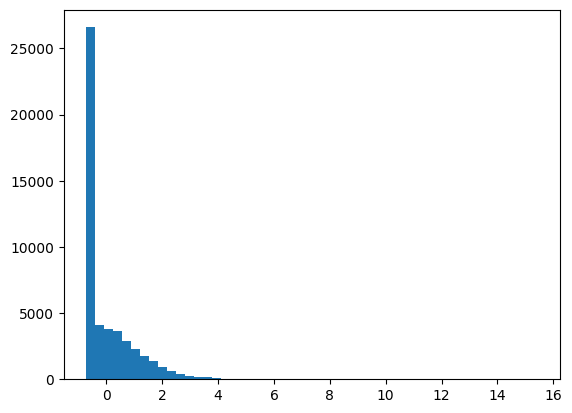

In [168]:
import matplotlib.pyplot as plt
plt.hist(X_train.reshape(-1), bins=50)
plt.show()


## LSTM



Article (Arora, 2023) states that they extracted high level features from the fifth LSTM layer with this configuration: 

* num_timesteps = 24 
* num_features = 1  
* num_layers = 5 
* units = [125, 100, 75, 50, 25] 
* dropout = 0.1


### side step - set up separate environment - too many issues instlling tensorfloww

1. gpu drivers
2. cuda toolkit, cuDNN
3. running in wsl


In [169]:
import tensorflow as tf

# Check if TensorFlow sees any GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # If GPUs are available, print the number of GPUs
    print("Num GPUs Available:", len(gpus))
else:
    print("No GPUs Available")



Num GPUs Available: 1


### LSTM model

Copy the configuration from the article.

In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# configuration
num_timesteps = 24 # X data shape 
num_features = 1  # Number of features
num_layers = 5 
units = [125, 100, 75, 50, 25] # Units in each LSTM layer
dropout = 0.1

model = Sequential()

#  LSTM layers  
for i in range(num_layers):
  model.add(LSTM(units[i], return_sequences=True, dropout=dropout)) 

#  connected output layer  
model.add(Dense(25)) 

# compile model
model.compile(loss='mean_squared_error', optimizer='adam') 

# generate features
features1 = model.predict(X_train)

65/65 [==============================] - 3s 10ms/step


In [171]:
# print the shape of the features
print(features1.shape)

(2057, 24, 25)


### Plot feature example

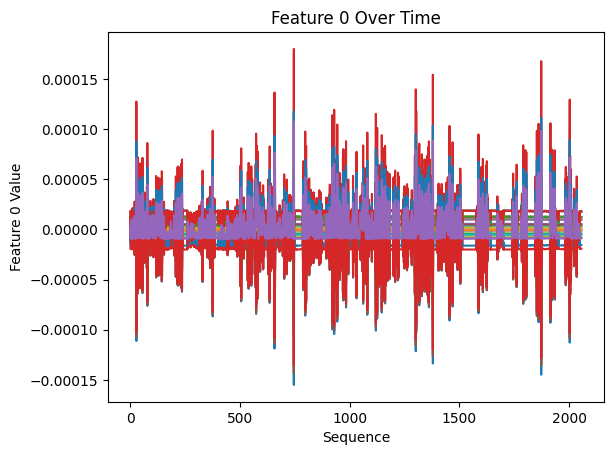

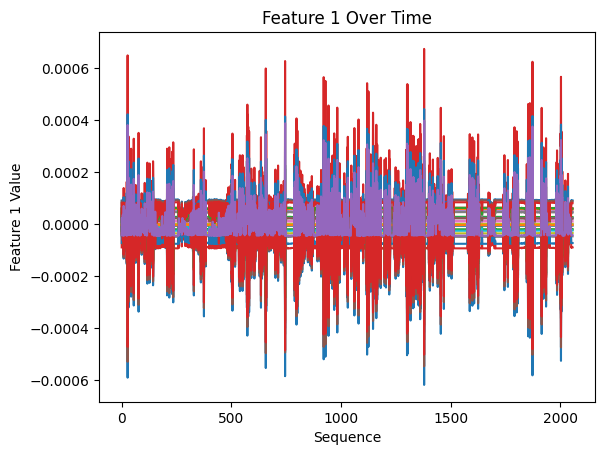

In [172]:
import matplotlib.pyplot as plt

# plot the first feature
plt.plot(features1[:,0]) 
plt.ylabel('Feature 0 Value')
plt.xlabel('Sequence')
plt.title('Feature 0 Over Time')
plt.show()

# plot the second feature
plt.plot(features1[:,1])
plt.ylabel('Feature 1 Value')
plt.xlabel('Sequence')
plt.title('Feature 1 Over Time')
plt.show()



### Perform PCA - n = 2

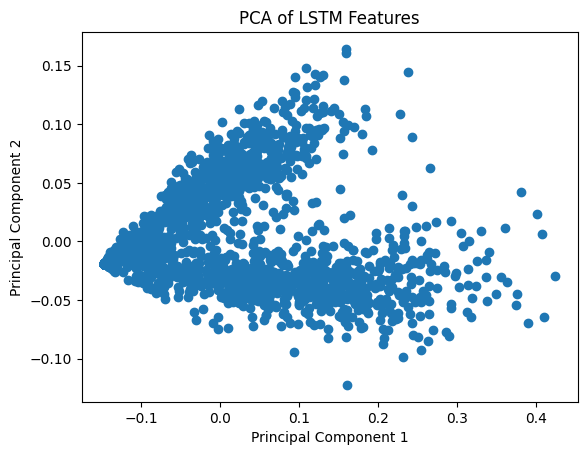

In [173]:


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca(features):
    """
    Plot the PCA of LSTM features.

    Parameters:
    features (numpy.ndarray): The LSTM features.

    Returns:
    None
    """
    # Flatten the features 
    flattened_features = features.reshape(features.shape[0], -1)

    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(flattened_features)
    plt.scatter(pca_features[:,0], pca_features[:,1])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of LSTM Features')
    plt.show()

# plot the PCA of the LSTM features
plot_pca(features1)


### Extract features from LSTM


In [174]:
from tensorflow.keras.models import Model

# create a model that outputs the feature representations of the LSTM layers
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[4].output)


In [175]:
# generate features
features = feature_extractor.predict(X_train)


65/65 [==============================] - 1s 8ms/step


In [176]:
# print shape of features
print(features.shape)

(2057, 24, 25)


In [177]:
# check if features and features2 are the same
print(np.allclose(features, features2))

False


### Statistical features

* mean
* std
* % zero activities

In [178]:


#  mean and standard deviation
mean_activity = np.mean(X_train, axis=1)
std_activity = np.std(X_train, axis=1)

#  percentage of zero activities
zero_activity = np.sum(X_train == 0, axis=1) / X_train.shape[1]


### Combine features

In [179]:
#  statistical features into one array
stat_features = np.hstack([mean_activity.reshape(-1, 1), std_activity.reshape(-1, 1), zero_activity.reshape(-1, 1)])
print(stat_features.shape)
print(stat_features[:5])


(2057, 3)
[[-0.09498505  0.5808358   0.        ]
 [-0.10704322  0.56905133  0.        ]
 [-0.22432436  0.49533169  0.        ]
 [-0.22415374  0.44898347  0.        ]
 [-0.18071804  0.48282368  0.        ]]


* Statistical features x 3
* LSTM features -> 24 timesteps * 25 features = 600


In [180]:
# flatten the LSTM features - 3D to 2D
flattened_features = features.reshape(features.shape[0], -1)

# Combine LSTM features and statistical features
combined_features = np.hstack([flattened_features, stat_features])
print(combined_features.shape)
print(combined_features[:5])


(2057, 603)
[[ 2.62403978e-06 -3.86794773e-06  9.55380983e-07 ... -9.49850543e-02
   5.80835797e-01  0.00000000e+00]
 [-1.03451350e-06  1.25902295e-06 -3.73586204e-07 ... -1.07043223e-01
   5.69051335e-01  0.00000000e+00]
 [ 1.68185227e-06 -2.37774566e-06  6.08931089e-07 ... -2.24324362e-01
   4.95331693e-01  0.00000000e+00]
 [-1.93066541e-07  2.45509653e-07 -6.93357123e-08 ... -2.24153741e-01
   4.48983468e-01  0.00000000e+00]
 [ 1.21114192e-06 -1.66818040e-06  4.35839752e-07 ... -1.80718043e-01
   4.82823683e-01  0.00000000e+00]]


## Linear SVM model

* fit linear SVM with `view_as_windows` to create the 'overlapping windows'


In [181]:
# check content of y_train
print(y_train[:5])

# print y_train shape
print(y_train.shape)

[1 1 1 1 1]
(2057,)


### Trying to understand the windows!

In [186]:
windows = view_as_windows(combined_features, window_shape=(window_size, combined_features.shape[1]), step=hop_size)
print("Shape of windows:", windows.shape)


Shape of windows: (170, 1, 24, 603)


In [187]:
windows = windows.reshape(windows.shape[0]*windows.shape[1], -1)
print("Shape of flattened windows:", windows.shape)


Shape of flattened windows: (170, 14472)


In [188]:
windowed_labels = view_as_windows(y_train, window_shape=(window_size,), step=hop_size)
print("Shape of windowed_labels:", windowed_labels.shape)


Shape of windowed_labels: (170, 24)


In [189]:
windowed_labels = windowed_labels.reshape(-1)
print("Shape of flattened windowed_labels:", windowed_labels.shape)


Shape of flattened windowed_labels: (4080,)


In [190]:
from skimage.util import view_as_windows
from sklearn import svm

# window size and hop size
window_size = 24
hop_size = 12

# overlapping windows for the features
windows = view_as_windows(combined_features, window_shape=(window_size, combined_features.shape[1]), step=hop_size)

# flatten the feature windows
windows = windows.reshape(windows.shape[0]*windows.shape[1], -1)

#  overlapping windows for the labels
windowed_labels = view_as_windows(y_train, window_shape=(window_size,), step=hop_size)

# flatten the label windows
windowed_labels = windowed_labels.reshape(-1)

#  one label for each window
windowed_labels = windowed_labels[::hop_size][:windows.shape[0]]

# train the SVM model
clf = svm.SVC(kernel='linear', C=0.1)
clf.fit(windows, windowed_labels)


SVC(C=0.1, kernel='linear')

In [192]:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# SVM model
#clf = svm.SVC(kernel='linear', C=0.1)

#  scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef)
}

#  10-fold cross-validation
cv_results = cross_validate(clf, windows, windowed_labels, cv=10, scoring=scoring)

# print cross-validation scores
for metric, scores in cv_results.items():
    print(f"{metric}: {scores}")




/home/zoonalink/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zoonalink/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zoonalink/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zoonali

fit_time: [0.47579074 0.16083479 0.18537378 0.13656116 0.23015904 0.49073124
 0.13562012 0.19269133 0.1324029  0.14945269]
score_time: [0.06451201 0.02536321 0.01585627 0.02690458 0.02235413 0.03381348
 0.01768208 0.02112579 0.02475834 0.25252342]
test_accuracy: [0.70588235 0.70588235 0.70588235 0.70588235 0.70588235 0.70588235
 0.70588235 0.70588235 0.70588235 0.64705882]
test_precision: [0.4982699  0.4982699  0.4982699  0.4982699  0.4982699  0.4982699
 0.4982699  0.4982699  0.4982699  0.41868512]
test_recall: [0.70588235 0.70588235 0.70588235 0.70588235 0.70588235 0.70588235
 0.70588235 0.70588235 0.70588235 0.64705882]
test_f1_score: [0.5841785  0.5841785  0.5841785  0.5841785  0.5841785  0.5841785
 0.5841785  0.5841785  0.5841785  0.50840336]
test_mcc: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/zoonalink/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusion

* After all that...the model does not perform any better than random chance.
* I thought I followed the exact set up described in the article but do not have anywhere near the same results.  
* Something must be quite wrong somewhere. 



## Train / Test split

## Models

### Import model libraries

### Define models (broken into sets -not sure of time needed)

## Model evaluation function

## Models

### Results - summary - out of the box models: 

* **Accuracy** - proportion of total predictions correct ->    `gradient boost`

$$\frac{{\text{{True Positive}} + \text{{True Negative}}}}{{\text{{Total Prediction}}}}$$

* **Precision**: proportion of positive prediction that are actually correct (Positive Predictive value) -> `neural network`
  
$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}}+ \text{{False Positives}}}}$$

* **Recall**: proportion of actual positives that are correctly identified (aka Sensitivity) -> `Naive Bayes`

$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}} + \text{{False Negatives}}}}$$

* **F1**: harmonic mean of Precision and Recall -> `gradient boost`

$$\frac{{{{2}} * \text{{(Precision}} * \text{{Recall)}}}}{{\text{{Precision}} + \text{{Recall}}}}$$

* **MCC**: measure of quality of binary classifications - considered a balanced measure ->  `gradient boost`

$$\frac{{\text{{(TP * TN - FP *FN)}}}}{{\text{{sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))}}}}$$

* **Quickest**: time ->  `Naive Bayes`



#### Reminder: 

* `True Positives (TP)`:  model predicted positive, and the truth is also positive.
* `True Negatives (TN)`:  model predicted negative, and the truth is also negative.
* `False Positives (FP)`: model predicted positive, and the truth is negative.
* `False Negatives (FN)`: model predicted negative, and the truth is positive.

## Visualise results
